In [30]:
# import fiona._loading
import geopandas as gpd
from geopandas import GeoDataFrame

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import datetime as dt
from dateutil.relativedelta import relativedelta
import pysal
import pymannkendall as mk
from pysal.explore import esda
from pysal.lib import weights
#from geovoronoi import voronoi_regions_from_coords, points_to_coords
from esda.moran import Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv
from esda.moran import Moran
from esda.moran import Moran_BV, Moran_Local_BV
from esda.moran import Moran_Local
from splot.esda import plot_moran
from pyproj import Proj, transform

from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

import urllib.request as urllib2

In [31]:
# pip list

In [32]:
# pip install splot

In [33]:
# pip install pysal

In [34]:
# pip install esda

In [35]:
# pip install pymannkendall

In [36]:
# os.chdir('D:\Gestion\Proyectos\GeoEspacial')
os.chdir('D:\\Will_Analisis\\')
analysis_dir = os.getcwd()

# data_dir = os.path.join(analysis_dir, 'Modelo_KPI_Calidad_Geo\\1_Datos')
data_dir= os.path.join(analysis_dir,'Proyect_churn\\Data\\')
result_dir= os.path.join(analysis_dir,'Proyect_churn\\')
data_geojson = os.path.join(analysis_dir, 'Datos\\Shapefiles\\')
# shape_dir = os.path.join(analysis_dir, 'Datos\\Shapefiles')

# C:\Users\WilsonAdolfoEstacioR\Documents\Datos\Shapefiles\HFC_UNIFICADO\1_ACTUAL

In [37]:
# start = datetime.now()

In [38]:
pd.set_option('display.max_columns', None)

In [39]:
Fija=pd.read_csv(os.path.join(data_dir,"202202\\Historico_churn_FIJA_2022_02.csv"), sep=";")  # esta actualizada 2022-02-01

In [40]:
Activos=pd.read_csv(os.path.join(data_dir,"202202\\Historco_activos.csv"), sep=";")

In [41]:
BetaMega=pd.read_csv(os.path.join(data_dir,"202202\\Historco_Beta.csv"), sep=";")  # data ol BETA_MEGA_FIJA_12 data new Historco_Beta

In [42]:
Fija.head(2)

,NODO,CUENTA,CANT_SERV,CANT_SERV1,RANGO_ANTIGUEDAD,ANTIGUEDAD_MESES,PERIODO_BAJA,RENTA,MOTIVO_DESCONEXION,CANT_F_CHURN,CANT_M_CHURN,EDAD,GENERACION_CHURN,DESCRIPCION_TIPO_CLIENTE,NO_CONVERGENTE_CHURN,SI_CONVERGENTE_CHURN,PAQ_INT_CHURN,PAQ_VOZ_CHURN,PAQ_TV_CHURN,CIUDAD,DIVISIONAL,MEGAS_CLARO_CHURN,ESTRATO
0,PSM,64620533,TRIPLE,3,2 A?OS,0,202111,0,NO DIO MOTIVO,1,0,42.0,GENERACION X,TITANIO,0,1,1,1,1,PEREIRA,REGION NOROCCIDENTE,100.0,6
1,LOL,83232119,SENCILLO,1,2 A?OS,9,202010,88808,NO USAR NCUMPLE REQUISI. FO CO,0,1,33.0,GENERACION Y O MILENIALS,PREFERENCIAL,1,0,0,1,0,BARRANQUILLA,REGION COSTA,NaN,3


In [43]:
Fija.PERIODO_BAJA.min()

202006

In [44]:
Activos.head(3)

,NODO,ANIO,MES,RENTA_ACT,PROM_RENTA_ACT,CANTIDAD,CANT_USER_HOGAR,CANT_USER_EMPRESARIAL,MODA_ESTRATO
0,JRR,2022,1,21051256,107404,196,194,2,3
1,49J,2022,1,3510915,117031,30,28,2,3
2,2TL,2022,1,32235660,94256,342,337,5,3


In [45]:
BetaMega.head(3)

,ANIO,MES,ALFA,BETA,MEGA,NODO
0,2022,1,0.561754,1.945455,0.288752,LMR
1,2021,2,0.486044,1.038136,0.468189,SU2
2,2021,4,0.516764,1.789668,0.288749,AUI


In [46]:
BetaMega.MES.max()

12

In [47]:
print(Fija.shape)
print(BetaMega.shape)
print(Activos.shape)   # no-bidirecional

(731110, 23)
(191365, 6)
(336049, 9)


In [48]:
# categori_columna_x=Fija.CIUDAD.unique()
# categori_columna_x

## Areglo datos para Fija

In [49]:
Fija['PERIODO_BAJA'] = Fija['PERIODO_BAJA'].apply(str)
Fija['ANIO']=Fija['PERIODO_BAJA'].str[:4]
Fija['MES']=Fija['PERIODO_BAJA'].str[4:]
Fija=Fija.drop(columns='PERIODO_BAJA')

Fija['MES']=Fija['MES'].astype(int)

Fija['DIA']=1 # le agrego la columna dia
Fija['MES'] = [f'0{x}' if x <10 else str(x) for x in Fija['MES']]
Fija['DIA'] = [f'0{x}' if x <10 else str(x) for x in Fija['DIA']]
Fija['FECHA'] = Fija['ANIO'] + '-' + Fija['MES'] + '-' + Fija['DIA']
Fija["FECHA"]=pd.to_datetime(Fija["FECHA"])
# eliminamos columnas
Fija=Fija.drop(['DIA','MES','ANIO'], axis=1)

Fija_2021=Fija.loc[Fija['FECHA'].dt.year == 2021]

In [50]:
Fija_2021.shape

(444839, 23)

In [51]:
# Fija_2021[Fija_2021['NODO']=='01S'].sort_values(['FECHA'])

In [52]:
Fija_2021['ESTRATO'] = Fija_2021['ESTRATO'].replace('NR',0)
Fija_2021['ESTRATO'] = Fija_2021['ESTRATO'].replace('NG',0)
Fija_2021['ESTRATO'] = Fija_2021['ESTRATO'].replace(np.nan,0)
Fija_2021['ESTRATO'] = Fija_2021['ESTRATO'].apply(int)

C:\Users\WILSON~1\AppData\Local\Temp/ipykernel_17432/3326343048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fija_2021['ESTRATO'] = Fija_2021['ESTRATO'].replace('NR',0)
C:\Users\WILSON~1\AppData\Local\Temp/ipykernel_17432/3326343048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fija_2021['ESTRATO'] = Fija_2021['ESTRATO'].replace('NG',0)
C:\Users\WILSON~1\AppData\Local\Temp/ipykernel_17432/3326343048.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [53]:
# Fija_2021[Fija_2021['NODO'].isin(["01J"])].sort_values(by="FECHA",ascending=True)

In [54]:
df_fija=Fija_2021.groupby(['NODO','FECHA']).agg({'NODO':'count','ESTRATO':pd.Series.mode,'MOTIVO_DESCONEXION':pd.Series.mode,'EDAD':np.mean,'RENTA':'sum'})

In [55]:
df_fija.rename(columns={'NODO':'CANTIDAD_CHURN'},inplace=True)

In [56]:
# df_fija=df_fija.reset_index()  # Opcional

In [57]:
df_fija.head()

CANTIDAD_CHURN ESTRATO          MOTIVO_DESCONEXION  EDAD  \
NODO FECHA                                                                  
01J  2021-05-01               1       3                    TRASLADO  59.0   
     2021-06-01               1       4  PRECIO Y CAPACIDAD DE PAGO  28.0   
     2021-08-01               1       3   FALLAS SERVICIO (CALIDAD)  64.0   
     2021-09-01               1       3  PRECIO Y CAPACIDAD DE PAGO  64.0   
     2021-12-01               1       3  PRECIO Y CAPACIDAD DE PAGO  69.0   

                  RENTA  
NODO FECHA               
01J  2021-05-01   65318  
     2021-06-01   87603  
     2021-08-01   50301  
     2021-09-01  163800  
     2021-12-01   81517

In [58]:
df_fija.shape

(125427, 5)

## Arreglo para beta y mega

In [59]:
BetaMega.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191365 entries, 0 to 191364
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ANIO    191365 non-null  int64  
 1   MES     191365 non-null  int64  
 2   ALFA    153160 non-null  float64
 3   BETA    170700 non-null  float64
 4   MEGA    161589 non-null  float64
 5   NODO    191365 non-null  object 
dtypes: float64(3), int64(2), object(1)
memory usage: 8.8+ MB


In [60]:
BetaMega['DIA']=1 # le agrego la columna dia
BetaMega['ANIO']=2021 # le agrego la columna dia
BetaMega['MES'] = [f'0{x}' if x <10 else str(x) for x in BetaMega['MES']]
BetaMega['DIA'] = [f'0{x}' if x <10 else str(x) for x in BetaMega['DIA']]
BetaMega['FECHA'] = BetaMega['ANIO'].astype('str') + '-' + BetaMega['MES'] + '-' + BetaMega['DIA']
BetaMega=BetaMega.drop(['DIA','MES','ANIO'], axis=1)
BetaMega["FECHA"]=pd.to_datetime(BetaMega["FECHA"])

In [61]:
BetaMega.shape

(191365, 5)

## Arreglo para Activos

In [62]:
Activos.head(1)

,NODO,ANIO,MES,RENTA_ACT,PROM_RENTA_ACT,CANTIDAD,CANT_USER_HOGAR,CANT_USER_EMPRESARIAL,MODA_ESTRATO
0,JRR,2022,1,21051256,107404,196,194,2,3


In [63]:
# Activos['ANIO']=Activos.str('ANIO')
Activos['ANIO']=Activos['ANIO'].apply(str)
# Activos['ANIO']=Activos['ANIO'].apply(str)

Activos['DIA']='01' # le agrego la columna dia
Activos['MES'] = [f'0{x}' if x <10 else str(x) for x in Activos['MES']]
# Activos['DIA'] = [f'0{x}' if x <10 else str(x) for x in Activos['DIA']]
Activos['FECHA'] = Activos['ANIO'] + '-' + Activos['MES'] + '-' + Activos['DIA']
Activos["FECHA"]=pd.to_datetime(Activos["FECHA"])
# eliminamos columnas
Activos=Activos.drop(['DIA','MES','ANIO'], axis=1)
Activos=Activos.drop(['CANT_USER_HOGAR','CANT_USER_EMPRESARIAL'], axis=1)

In [64]:
Activos.shape

(336049, 6)

In [65]:
df_fijaN1=pd.merge(Activos, BetaMega,on = ('NODO','FECHA'), how='left')

In [66]:
df_fija1=pd.merge(df_fija, df_fijaN1, on = ('NODO','FECHA'), how='left')

In [67]:
df_fija1.shape

(145322, 14)

In [68]:
df_fija1

,NODO,FECHA,CANTIDAD_CHURN,ESTRATO,MOTIVO_DESCONEXION,EDAD,RENTA,RENTA_ACT,PROM_RENTA_ACT,CANTIDAD,MODA_ESTRATO,ALFA,BETA,MEGA
0,01J,2021-05-01,1,3,TRASLADO,59.000000,65318,2856137.0,109851.0,26.0,3,NaN,NaN,0.391503
1,01J,2021-06-01,1,4,PRECIO Y CAPACIDAD DE PAGO,28.000000,87603,2701846.0,108074.0,25.0,3,NaN,1.076655,NaN
2,01J,2021-08-01,1,3,FALLAS SERVICIO (CALIDAD),64.000000,50301,2507252.0,109011.0,23.0,3,NaN,1.942857,NaN
3,01J,2021-09-01,1,3,PRECIO Y CAPACIDAD DE PAGO,64.000000,163800,2702401.0,112600.0,24.0,3,0.277625,1.515152,0.183232
4,01J,2021-12-01,1,3,PRECIO Y CAPACIDAD DE PAGO,69.000000,81517,2627094.0,105084.0,25.0,3,NaN,NaN,1.859166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145317,ZVZ,2021-08-01,3,3,"[FALLAS SERVICIO (CALIDAD), NO USAR NCUMPLE RE...",43.666667,392700,47377762.0,106948.0,443.0,3,1.492830,1.481245,1.007821
145318,ZVZ,2021-09-01,6,3,NO DIO MOTIVO,52.000000,542560,49123128.0,110142.0,446.0,3,1.604062,1.639118,0.978613
145319,ZVZ,2021-10-01,3,3,NO DIO MOTIVO,42.333333,571547,49136627.0,110419.0,445.0,3,0.583469,1.106707,0.527211
145320,ZVZ,2021-11-01,4,3,"[FALLAS SERVICIO (CALIDAD), NO DIO MOTIVO, NO ...",51.500000,455530,48974972.0,109564.0,447.0,3,1.920703,1.729134,1.110789


In [69]:
# Activos['NODO'] = Activos['NODO'].map({"14B13B": '14B', "CV53": 'CV5',"F1G3B": 'F1G', "JG31": 'JG3', "BA4A": 'BA4', "SRG3B": 'SRG',"RSJ3B": 'RSJ'})

In [70]:
# df_fija1.head(2)

In [71]:
df_fija1['CANTIDAD_ACTIVOS']=df_fija1['CANTIDAD']+df_fija1['CANTIDAD_CHURN']
df_fija1 = df_fija1.dropna(subset=["CANTIDAD_ACTIVOS"])
df_fija1['CANTIDAD_ACTIVOS']=df_fija1['CANTIDAD_ACTIVOS'].apply(int)

C:\Users\WILSON~1\AppData\Local\Temp/ipykernel_17432/2765932099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fija1['CANTIDAD_ACTIVOS']=df_fija1['CANTIDAD_ACTIVOS'].apply(int)


In [72]:
df_fija1.head(2)

,NODO,FECHA,CANTIDAD_CHURN,ESTRATO,MOTIVO_DESCONEXION,EDAD,RENTA,RENTA_ACT,PROM_RENTA_ACT,CANTIDAD,MODA_ESTRATO,ALFA,BETA,MEGA,CANTIDAD_ACTIVOS
0,01J,2021-05-01,1,3,TRASLADO,59.0,65318,2856137.0,109851.0,26.0,3,NaN,NaN,0.391503,27
1,01J,2021-06-01,1,4,PRECIO Y CAPACIDAD DE PAGO,28.0,87603,2701846.0,108074.0,25.0,3,NaN,1.076655,NaN,26


In [73]:
# df_fija1[df_fija1['CANTIDAD_ACTIVOS'].isna()]

In [74]:
# df_fija1.isnull().sum().sort_values(ascending=False,)[:21]

In [75]:
df_fija1.shape

(145276, 15)

In [76]:
df_fija1['TasaChurn']=np.where(df_fija1['CANTIDAD_ACTIVOS'] !=0,df_fija1['CANTIDAD_CHURN'].div(df_fija1['CANTIDAD_ACTIVOS']),0)

C:\Users\WILSON~1\AppData\Local\Temp/ipykernel_17432/329146815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fija1['TasaChurn']=np.where(df_fija1['CANTIDAD_ACTIVOS'] !=0,df_fija1['CANTIDAD_CHURN'].div(df_fija1['CANTIDAD_ACTIVOS']),0)


In [77]:
df_fija1['FechaVal_AñoMes'] = df_fija1['FECHA'].dt.strftime('Churn_''%Y_%m')

C:\Users\WILSON~1\AppData\Local\Temp/ipykernel_17432/2752838023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fija1['FechaVal_AñoMes'] = df_fija1['FECHA'].dt.strftime('Churn_''%Y_%m')


In [78]:
df_fija1.head(2)

,NODO,FECHA,CANTIDAD_CHURN,ESTRATO,MOTIVO_DESCONEXION,EDAD,RENTA,RENTA_ACT,PROM_RENTA_ACT,CANTIDAD,MODA_ESTRATO,ALFA,BETA,MEGA,CANTIDAD_ACTIVOS,TasaChurn,FechaVal_AñoMes
0,01J,2021-05-01,1,3,TRASLADO,59.0,65318,2856137.0,109851.0,26.0,3,NaN,NaN,0.391503,27,0.037037,Churn_2021_05
1,01J,2021-06-01,1,4,PRECIO Y CAPACIDAD DE PAGO,28.0,87603,2701846.0,108074.0,25.0,3,NaN,1.076655,NaN,26,0.038462,Churn_2021_06


In [79]:
# copiamos un fija1 para analizarlo abajo en la parte monetaria
df_fija_CM=df_fija1.copy()

In [80]:
# para encontrar el promedio nacional 2021
df_fija1.describe()

,CANTIDAD_CHURN,EDAD,RENTA,RENTA_ACT,PROM_RENTA_ACT,CANTIDAD,ALFA,BETA,MEGA,CANTIDAD_ACTIVOS,TasaChurn
count,145276.000000,143508.000000,1.452760e+05,1.452760e+05,145276.000000,145276.000000,121777.000000,134209.000000,125996.000000,145276.000000,145276.000000
mean,3.496290,42.416399,3.470421e+05,2.474924e+07,106020.282875,243.702311,1.518237,1.523913,1.015672,247.198601,0.016927
std,2.907326,10.856214,3.033602e+05,1.471223e+07,18950.340651,152.057107,3.174431,2.443786,0.710579,153.698069,0.014637
min,1.000000,18.000000,0.000000e+00,5.000000e+04,11342.000000,1.000000,0.000000,0.041667,0.000000,2.000000,0.001253
25%,1.000000,35.000000,1.410050e+05,1.324288e+07,93067.750000,122.000000,0.544133,0.900990,0.501945,124.000000,0.008929
50%,3.000000,41.250000,2.689620e+05,2.280334e+07,106028.000000,223.000000,1.080789,1.194030,0.905668,227.000000,0.013793
75%,5.000000,48.500000,4.576535e+05,3.360731e+07,115882.250000,335.000000,1.864384,1.620915,1.410248,339.000000,0.020833
max,80.000000,96.000000,8.991263e+06,1.213819e+08,226532.000000,1366.000000,321.525391,138.000000,34.352322,1391.000000,0.666667


In [81]:
df_fija_pv = pd.pivot_table(df_fija1, index = "NODO", columns=['FechaVal_AñoMes'], values='TasaChurn')
df_fija_pv.fillna(0,inplace=True)
df_fija_pv = df_fija_pv.reset_index()
# df_fija_pv.to_csv(os.path.join(result_dir,'Fija\\Resultados\\ChurnActivosFijaPivot.csv'), sep = ';')
df_fija_pv

FechaVal_AñoMes,NODO,Churn_2021_01,Churn_2021_02,Churn_2021_03,Churn_2021_04,Churn_2021_05,Churn_2021_06,Churn_2021_07,Churn_2021_08,Churn_2021_09,Churn_2021_10,Churn_2021_11,Churn_2021_12
0,01J,0.000000,0.000000,0.000000,0.000000,0.037037,0.038462,0.000000,0.041667,0.040000,0.000000,0.000000,0.038462
1,01S,0.000000,0.006098,0.018405,0.011834,0.011561,0.017341,0.016667,0.005682,0.000000,0.026455,0.016667,0.020942
2,02J,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000
3,02S,0.007353,0.028777,0.007194,0.013514,0.006711,0.013699,0.013333,0.029940,0.012195,0.013423,0.006897,0.019108
4,03J,0.058824,0.000000,0.000000,0.000000,0.000000,0.058824,0.062500,0.000000,0.033333,0.066667,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13487,ZVD,0.045098,0.058594,0.046154,0.035714,0.011468,0.020930,0.011848,0.033816,0.021583,0.024331,0.015504,0.010256
13488,ZVG,0.023952,0.006042,0.021212,0.015432,0.018405,0.019048,0.025316,0.022801,0.016556,0.006645,0.006780,0.006645
13489,ZVS,0.008351,0.018367,0.014433,0.012526,0.018557,0.012448,0.010482,0.008282,0.010246,0.018145,0.021053,0.016293
13490,ZVT,0.000000,0.007463,0.014388,0.028369,0.007299,0.000000,0.006944,0.006993,0.006944,0.007042,0.014085,0.006993


In [82]:
#Banderas TasaChurn superior a promedio NAL 0.018 y 0.025
PromedioNal = 0.017 # 0.018 0.017009
 
df_fija_pv.loc[(df_fija_pv['Churn_2021_01']>PromedioNal),'flgAvgNalChurn_2021_01'] = 1
df_fija_pv.loc[(df_fija_pv['Churn_2021_02']>PromedioNal),'flgAvgNalChurn_2021_02'] = 1
df_fija_pv.loc[(df_fija_pv['Churn_2021_03']>PromedioNal),'flgAvgNalChurn_2021_03'] = 1
df_fija_pv.loc[(df_fija_pv['Churn_2021_04']>PromedioNal),'flgAvgNalChurn_2021_04'] = 1
df_fija_pv.loc[(df_fija_pv['Churn_2021_05']>PromedioNal),'flgAvgNalChurn_2021_05'] = 1
df_fija_pv.loc[(df_fija_pv['Churn_2021_06']>PromedioNal),'flgAvgNalChurn_2021_06'] = 1
df_fija_pv.loc[(df_fija_pv['Churn_2021_07']>PromedioNal),'flgAvgNalChurn_2021_07'] = 1
df_fija_pv.loc[(df_fija_pv['Churn_2021_08']>PromedioNal),'flgAvgNalChurn_2021_08'] = 1
df_fija_pv.loc[(df_fija_pv['Churn_2021_09']>PromedioNal),'flgAvgNalChurn_2021_09'] = 1
df_fija_pv.loc[(df_fija_pv['Churn_2021_10']>PromedioNal),'flgAvgNalChurn_2021_10'] = 1
df_fija_pv.loc[(df_fija_pv['Churn_2021_11']>PromedioNal),'flgAvgNalChurn_2021_11'] = 1
df_fija_pv.loc[(df_fija_pv['Churn_2021_12']>PromedioNal),'flgAvgNalChurn_2021_12'] = 1

df_fija_pv.fillna(0,inplace=True)

In [83]:
df_fija_pv.head(2)

FechaVal_AñoMes,NODO,Churn_2021_01,Churn_2021_02,Churn_2021_03,Churn_2021_04,Churn_2021_05,Churn_2021_06,Churn_2021_07,Churn_2021_08,Churn_2021_09,Churn_2021_10,Churn_2021_11,Churn_2021_12,flgAvgNalChurn_2021_01,flgAvgNalChurn_2021_02,flgAvgNalChurn_2021_03,flgAvgNalChurn_2021_04,flgAvgNalChurn_2021_05,flgAvgNalChurn_2021_06,flgAvgNalChurn_2021_07,flgAvgNalChurn_2021_08,flgAvgNalChurn_2021_09,flgAvgNalChurn_2021_10,flgAvgNalChurn_2021_11,flgAvgNalChurn_2021_12
0,01J,0.0,0.000000,0.000000,0.000000,0.037037,0.038462,0.000000,0.041667,0.04,0.000000,0.000000,0.038462,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1,01S,0.0,0.006098,0.018405,0.011834,0.011561,0.017341,0.016667,0.005682,0.00,0.026455,0.016667,0.020942,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [84]:
#Calculo promedio por nodo superior a tasa Churn 
# ChurnActivosFija_pv["Flag_AvgNal_2020"] = ChurnActivosFija_pv.filter(like='flgAvgNalChurn_2020').sum(axis=1)
df_fija_pv["Flag_AvgNal_2021"] = df_fija_pv.filter(like='flgAvgNalChurn_2021').sum(axis=1)
# df_fija_pv["Flag_AvgNal_TOTAL"] = df_fija_pv.filter(like='flgAvgNalChurn').sum(axis=1)
# ChurnActivosFija_pv["Flag_AvgNal_Tasa_2020"] = ChurnActivosFija_pv.filter(like='flgAvgNalChurn_2020').sum(axis=1)/ChurnActivosFija_pv.filter(like='flgAvgNalChurn_2020').count(axis=1)
df_fija_pv["Flag_AvgNal_Tasa_2021"] = df_fija_pv.filter(like='flgAvgNalChurn_2021').sum(axis=1)/df_fija_pv.filter(like='flgAvgNalChurn_2021').count(axis=1)
# df_fija_pv["Flag_AvgNal_Tasa_TOTAL"] = df_fija_pv.filter(like='flgAvgNalChurn').sum(axis=1)/df_fija_pv.filter(like='flgAvgNalChurn').count(axis=1)

In [85]:
# df_fija_pv.to_csv(os.path.join(result_dir,'Fija\\Resultados\\ChurnActivosFija.csv'), sep = ';')

In [86]:
df_fija_pv['selecion']=1

In [87]:
df_fija_pv["selecion"].value_counts()[:30]

1    13492
Name: selecion, dtype: int64

In [88]:
df_fija_pv.shape

(13492, 28)

In [89]:
df_fija_pv

FechaVal_AñoMes,NODO,Churn_2021_01,Churn_2021_02,Churn_2021_03,Churn_2021_04,Churn_2021_05,Churn_2021_06,Churn_2021_07,Churn_2021_08,Churn_2021_09,Churn_2021_10,Churn_2021_11,Churn_2021_12,flgAvgNalChurn_2021_01,flgAvgNalChurn_2021_02,flgAvgNalChurn_2021_03,flgAvgNalChurn_2021_04,flgAvgNalChurn_2021_05,flgAvgNalChurn_2021_06,flgAvgNalChurn_2021_07,flgAvgNalChurn_2021_08,flgAvgNalChurn_2021_09,flgAvgNalChurn_2021_10,flgAvgNalChurn_2021_11,flgAvgNalChurn_2021_12,Flag_AvgNal_2021,Flag_AvgNal_Tasa_2021,selecion
0,01J,0.000000,0.000000,0.000000,0.000000,0.037037,0.038462,0.000000,0.041667,0.040000,0.000000,0.000000,0.038462,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,5.0,0.416667,1
1,01S,0.000000,0.006098,0.018405,0.011834,0.011561,0.017341,0.016667,0.005682,0.000000,0.026455,0.016667,0.020942,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0,0.333333,1
2,02J,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.083333,1
3,02S,0.007353,0.028777,0.007194,0.013514,0.006711,0.013699,0.013333,0.029940,0.012195,0.013423,0.006897,0.019108,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.250000,1
4,03J,0.058824,0.000000,0.000000,0.000000,0.000000,0.058824,0.062500,0.000000,0.033333,0.066667,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,5.0,0.416667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13487,ZVD,0.045098,0.058594,0.046154,0.035714,0.011468,0.020930,0.011848,0.033816,0.021583,0.024331,0.015504,0.010256,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,8.0,0.666667,1
13488,ZVG,0.023952,0.006042,0.021212,0.015432,0.018405,0.019048,0.025316,0.022801,0.016556,0.006645,0.006780,0.006645,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,6.0,0.500000,1
13489,ZVS,0.008351,0.018367,0.014433,0.012526,0.018557,0.012448,0.010482,0.008282,0.010246,0.018145,0.021053,0.016293,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,0.333333,1
13490,ZVT,0.000000,0.007463,0.014388,0.028369,0.007299,0.000000,0.006944,0.006993,0.006944,0.007042,0.014085,0.006993,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.083333,1


## Lisa

In [90]:
inProj = Proj(init='EPSG:4326')
outProj = Proj(init='EPSG:3857')
MSh=gpd.read_file(os.path.join(data_dir, "HFC_FTTH\\HFC_FTTH.shp"))
MSh = MSh.to_crs('EPSG:3857')

C:\ProgramData\Anaconda3\envs\sqdm\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\ProgramData\Anaconda3\envs\sqdm\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\ProgramData\Anaconda3\envs\sqdm\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.

In [91]:
MSH=MSh.drop(["NOMBRE","DEPARTAMEN","Shape_Leng","Shape_Area"], axis=1)

In [92]:
# MSH=MSH.drop_duplicates(subset=['NODO'])

In [93]:
MSH.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [94]:
# inProj = Proj(init='EPSG:4326')
# outProj = Proj(init='EPSG:3857')
# df_fijaG=pd.merge(df_fija_pv, MSH, on = ('NODO'), how='left')   # right
# df_fijaG1=pd.merge(MSH, df_fija_pv, on = ('NODO'), how='right')   # right
# # df_fijaG = df_fijaG.to_crs("EPSG:3857")
df_fijaG = pd.merge(left = MSH, right = df_fija_pv, how = 'left', left_on = 'NODO', right_on = 'NODO')
# df_fijaG = df_fijaG.to_crs('EPSG:3857')

In [95]:
df_fijaG[df_fijaG['NODO']=='SLJ']

,NODO,TIPO,geometry,Churn_2021_01,Churn_2021_02,Churn_2021_03,Churn_2021_04,Churn_2021_05,Churn_2021_06,Churn_2021_07,Churn_2021_08,Churn_2021_09,Churn_2021_10,Churn_2021_11,Churn_2021_12,flgAvgNalChurn_2021_01,flgAvgNalChurn_2021_02,flgAvgNalChurn_2021_03,flgAvgNalChurn_2021_04,flgAvgNalChurn_2021_05,flgAvgNalChurn_2021_06,flgAvgNalChurn_2021_07,flgAvgNalChurn_2021_08,flgAvgNalChurn_2021_09,flgAvgNalChurn_2021_10,flgAvgNalChurn_2021_11,flgAvgNalChurn_2021_12,Flag_AvgNal_2021,Flag_AvgNal_Tasa_2021,selecion
160,SLJ,HFC,"POLYGON Z ((-8240124.075 520378.497 0.000, -82...",0.00625,0.006173,0.011628,0.021164,0.010101,0.004854,0.018692,0.0131,0.021368,0.008889,0.004386,0.024896,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,4.0,0.333333,1.0
9469,SLJ,HFC,"POLYGON Z ((-8240124.075 520378.497 0.000, -82...",0.00625,0.006173,0.011628,0.021164,0.010101,0.004854,0.018692,0.0131,0.021368,0.008889,0.004386,0.024896,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,4.0,0.333333,1.0


In [96]:
print(df_fijaG.groupby('selecion').size())

selecion
1.0    13344
dtype: int64


In [97]:
df_fijaG.shape

(17329, 30)

In [98]:
df_fijaG3=df_fijaG[df_fijaG['selecion']==1]

In [99]:
df_fijaG3.shape

(13344, 30)

In [100]:
df_fijaG3.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [101]:
#NodosChurnActivosFija_pv_geo.reset_index(inplace=True)
coords = points_to_coords(df_fijaG3.geometry.centroid)

q_d=weights.DistanceBand(coords, threshold=1550, binary=False) ##Límite en grados 1/200 ~ 555 mt.
q_d.transform='R'
# Para calcular el desfase espacial de una variable dada siguenlas sig dos filas
TasaCompare = df_fijaG3['Flag_AvgNal_Tasa_2021']
df_fijaG3['w_Flag_AvgNal_CHURN']=weights.spatial_lag.lag_spatial(q_d, TasaCompare)

C:\ProgramData\Anaconda3\envs\sqdm\lib\site-packages\pysal\lib\weights\weights.py:167: UserWarning: There are 24 disconnected observations 
  Island ids: 553, 857, 870, 2059, 2064, 2066, 2069, 2079, 2610, 3316, 3318, 3323, 3368, 3521, 3523, 3782, 4604, 6129, 10749, 10772, 12133, 12321, 12807, 13332
  warnings.warn("There are %d disconnected observations" % ni + ' \n '


('WARNING: ', 553, ' is an island (no neighbors)')
('WARNING: ', 857, ' is an island (no neighbors)')
('WARNING: ', 870, ' is an island (no neighbors)')
('WARNING: ', 2059, ' is an island (no neighbors)')
('WARNING: ', 2064, ' is an island (no neighbors)')
('WARNING: ', 2066, ' is an island (no neighbors)')
('WARNING: ', 2069, ' is an island (no neighbors)')
('WARNING: ', 2079, ' is an island (no neighbors)')
('WARNING: ', 2610, ' is an island (no neighbors)')
('WARNING: ', 3316, ' is an island (no neighbors)')
('WARNING: ', 3318, ' is an island (no neighbors)')
('WARNING: ', 3323, ' is an island (no neighbors)')
('WARNING: ', 3368, ' is an island (no neighbors)')
('WARNING: ', 3521, ' is an island (no neighbors)')
('WARNING: ', 3523, ' is an island (no neighbors)')
('WARNING: ', 3782, ' is an island (no neighbors)')
('WARNING: ', 4604, ' is an island (no neighbors)')
('WARNING: ', 6129, ' is an island (no neighbors)')
('WARNING: ', 10749, ' is an island (no neighbors)')
('WARNING: ', 

C:\ProgramData\Anaconda3\envs\sqdm\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [112]:
# w = weights.KNN.from_dataframe(df_fijaG3, k=8)
# w.transform = 'R'
# moran = esda.moran.Moran(df_fijaG3['Flag_AvgNal_Tasa_2021'], w)

In [102]:
# inicion notas


In [103]:
# Podemos calcular la estadística como:  esto para casos de variables binrias
jc = esda.join_counts.Join_Counts(TasaCompare, q_d)
jc

In [104]:
jc.bb  # para ver cuantas ocurrencias GG tenemos

632.2651438689136

In [105]:
jc.ww  # y cauntas ocurrencias YY tenemos en nuestro mapa

3428.397603137798

In [106]:
# y cuántos GY/YG encontramos:
jc.bw

2599.3372529932885

In [107]:
# La suma de esos tres nos da el número total de comparaciones:
jc.bb + jc.ww + jc.bw

6660.0

In [108]:
jc.J

6660.0

In [109]:
jc.mean_bb  # para el caso GG/YY La estadística se basa en comparar el número real de uniones de cada clase

557.2235505598203

In [110]:
jc.mean_bw  # y para GY

2738.431789149267

In [131]:
# Se puede acceder a la inferencia estadística para obtener una idea de si es probable que estos valores provengan del azar aleatorio o no utilizando permutaciones espaciales aleatorias de los valores observados para crear mapas sintéticos bajo la hipótesis nula de aleatoriedad espacial completa.
#  genera 999 tales patrones sintéticos y luego utiliza la distribución de recuentos de unión a partir de estos patrones para generar pseudovalores para nuestras estadísticas de recuento de uniones observadas:pysal
jc.p_sim_bb

0.001

In [132]:
jc.p_sim_bw

1.0

Estos resultados apuntan a una clara presencia de autocorrelación espacial positiva, ya que hay muchas más uniones de pares en la misma categoría de lo que uno esperaría
y significativamente menos de uniones opuestas

In [111]:
# fin notas

In [139]:
# para evaluar la autocorrelacion espacial en caso no binario, en caso de que la variable es continua
# El método crea un objeto que contiene mucha más información que la estadística real. Si queremos recuperar el valor de la estadística, podemos hacerlo de esta manera:Moran
moran = esda.moran.Moran(TasaCompare , q_d)

In [140]:
# el valor de la I de Moran se corresponde con la pendiente del ajuste lineal sobrepuesto en la parte superior de la trama de Moran. un I mas cercano a uno indica mayor correlacion espacia, o relacion entre valores de forma espacial
moran.I

0.291690197035515

In [141]:
moran.p_sim  # realiza una simulación y devuelve una medida de certeza sobre la probabilidad de obtener un patrón como el que observamos bajo un proceso espacialmente aleatorio.

0.001

In [152]:
# plot_moran(moran);

C:\ProgramData\Anaconda3\envs\sqdm\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


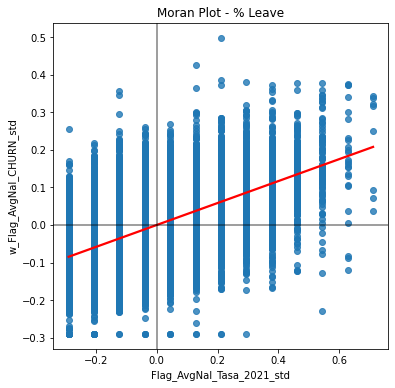

In [145]:
# otra forma se sacar la relaciionn 
df_fijaG3['Flag_AvgNal_Tasa_2021_std'] = ( df_fijaG3['Flag_AvgNal_Tasa_2021'] - df_fijaG3['Flag_AvgNal_Tasa_2021'].mean() )
df_fijaG3['w_Flag_AvgNal_CHURN_std'] = ( df_fijaG3['w_Flag_AvgNal_CHURN'] - df_fijaG3['w_Flag_AvgNal_CHURN'].mean() )

f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x='Flag_AvgNal_Tasa_2021_std', y='w_Flag_AvgNal_CHURN_std', 
                ci=None, data=df_fijaG3, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - % Leave')
plt.show()

In [120]:
df_fijaG3['Flag_AvgNal_Tasa_2021_std'] = ( TasaCompare - TasaCompare.mean() )/ TasaCompare.std()
df_fijaG3['w_Flag_AvgNal_CHURN_std'] = ( df_fijaG3['w_Flag_AvgNal_CHURN'] - TasaCompare.mean() )/ TasaCompare.std()

C:\ProgramData\Anaconda3\envs\sqdm\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [121]:
df_fijaG3.head(2)

,NODO,TIPO,geometry,Churn_2021_01,Churn_2021_02,Churn_2021_03,Churn_2021_04,Churn_2021_05,Churn_2021_06,Churn_2021_07,Churn_2021_08,Churn_2021_09,Churn_2021_10,Churn_2021_11,Churn_2021_12,flgAvgNalChurn_2021_01,flgAvgNalChurn_2021_02,flgAvgNalChurn_2021_03,flgAvgNalChurn_2021_04,flgAvgNalChurn_2021_05,flgAvgNalChurn_2021_06,flgAvgNalChurn_2021_07,flgAvgNalChurn_2021_08,flgAvgNalChurn_2021_09,flgAvgNalChurn_2021_10,flgAvgNalChurn_2021_11,flgAvgNalChurn_2021_12,Flag_AvgNal_2021,Flag_AvgNal_Tasa_2021,selecion,w_Flag_AvgNal_CHURN,Flag_AvgNal_Tasa_2021_std,w_Flag_AvgNal_CHURN_std
0,LSU,HFC,"POLYGON Z ((-8236564.189 560360.757 0.000, -82...",0.010288,0.008180,0.025048,0.003984,0.005703,0.011321,0.027829,0.016981,0.020599,0.018939,0.013308,0.024164,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,5.0,0.416667,1.0,0.286419,0.662463,-0.014753
1,EDZ,HFC,"POLYGON Z ((-8236551.499 560363.104 0.000, -82...",0.015317,0.004405,0.020964,0.023158,0.018634,0.031056,0.031250,0.012931,0.018634,0.017241,0.023355,0.023707,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,9.0,0.750000,1.0,0.230361,2.395608,-0.306224


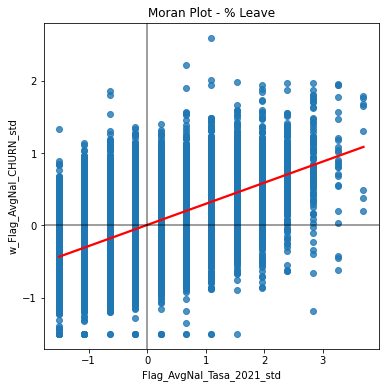

In [122]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x='Flag_AvgNal_Tasa_2021_std', y='w_Flag_AvgNal_CHURN_std', 
                ci=None, data=df_fijaG3, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - % Leave')
plt.show()

In [123]:
# ##Setup the figure and axis
# f, ax = plt.subplots(1, figsize=(6, 6))
# # Plot values
# sns.regplot(x='Flag_AvgNal_Tasa_2021_std', y='w_Flag_AvgNal_CHURN_std', data=df_fijaG3, ci=None)
# # Display
# plt.show()

In [124]:
# df_fijaG3.explore()

<AxesSubplot:>

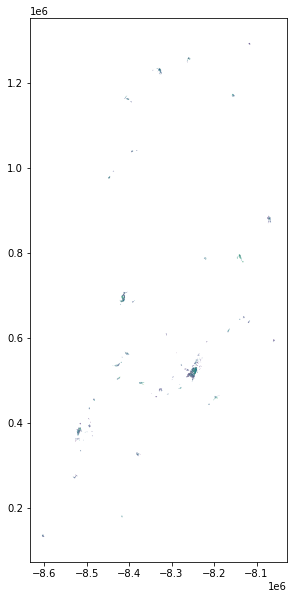

In [125]:
df_fijaG3.plot(column='w_Flag_AvgNal_CHURN', figsize=(12,10))

In [126]:
df_fijaG3.head(2)

,NODO,TIPO,geometry,Churn_2021_01,Churn_2021_02,Churn_2021_03,Churn_2021_04,Churn_2021_05,Churn_2021_06,Churn_2021_07,Churn_2021_08,Churn_2021_09,Churn_2021_10,Churn_2021_11,Churn_2021_12,flgAvgNalChurn_2021_01,flgAvgNalChurn_2021_02,flgAvgNalChurn_2021_03,flgAvgNalChurn_2021_04,flgAvgNalChurn_2021_05,flgAvgNalChurn_2021_06,flgAvgNalChurn_2021_07,flgAvgNalChurn_2021_08,flgAvgNalChurn_2021_09,flgAvgNalChurn_2021_10,flgAvgNalChurn_2021_11,flgAvgNalChurn_2021_12,Flag_AvgNal_2021,Flag_AvgNal_Tasa_2021,selecion,w_Flag_AvgNal_CHURN,Flag_AvgNal_Tasa_2021_std,w_Flag_AvgNal_CHURN_std
0,LSU,HFC,"POLYGON Z ((-8236564.189 560360.757 0.000, -82...",0.010288,0.008180,0.025048,0.003984,0.005703,0.011321,0.027829,0.016981,0.020599,0.018939,0.013308,0.024164,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,5.0,0.416667,1.0,0.286419,0.662463,-0.014753
1,EDZ,HFC,"POLYGON Z ((-8236551.499 560363.104 0.000, -82...",0.015317,0.004405,0.020964,0.023158,0.018634,0.031056,0.031250,0.012931,0.018634,0.017241,0.023355,0.023707,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,9.0,0.750000,1.0,0.230361,2.395608,-0.306224


In [127]:
df_fijaG3.shape

(13344, 33)

In [128]:
lisa_cuenta = esda.moran.Moran_Local(df_fijaG3['w_Flag_AvgNal_CHURN'], q_d)
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]

df_fijaG3['cl_Flag_AvgNal_CHURN']=labels_cuenta
df_fijaG3['cl_Flag_AvgNal_CHURN']=df_fijaG3['cl_Flag_AvgNal_CHURN'].apply(lambda x: 'A-A' if x=='Q1' else ('B-A' if x=='Q2' else ('B-B' if x=='Q3' else 'A-B')) )

## A-A ES ALTA CORRELACION Y ALTA

C:\ProgramData\Anaconda3\envs\sqdm\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [129]:
df_fijaG3.head(3)

,NODO,TIPO,geometry,Churn_2021_01,Churn_2021_02,Churn_2021_03,Churn_2021_04,Churn_2021_05,Churn_2021_06,Churn_2021_07,Churn_2021_08,Churn_2021_09,Churn_2021_10,Churn_2021_11,Churn_2021_12,flgAvgNalChurn_2021_01,flgAvgNalChurn_2021_02,flgAvgNalChurn_2021_03,flgAvgNalChurn_2021_04,flgAvgNalChurn_2021_05,flgAvgNalChurn_2021_06,flgAvgNalChurn_2021_07,flgAvgNalChurn_2021_08,flgAvgNalChurn_2021_09,flgAvgNalChurn_2021_10,flgAvgNalChurn_2021_11,flgAvgNalChurn_2021_12,Flag_AvgNal_2021,Flag_AvgNal_Tasa_2021,selecion,w_Flag_AvgNal_CHURN,Flag_AvgNal_Tasa_2021_std,w_Flag_AvgNal_CHURN_std,cl_Flag_AvgNal_CHURN
0,LSU,HFC,"POLYGON Z ((-8236564.189 560360.757 0.000, -82...",0.010288,0.008180,0.025048,0.003984,0.005703,0.011321,0.027829,0.016981,0.020599,0.018939,0.013308,0.024164,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,5.0,0.416667,1.0,0.286419,0.662463,-0.014753,B-B
1,EDZ,HFC,"POLYGON Z ((-8236551.499 560363.104 0.000, -82...",0.015317,0.004405,0.020964,0.023158,0.018634,0.031056,0.031250,0.012931,0.018634,0.017241,0.023355,0.023707,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,9.0,0.750000,1.0,0.230361,2.395608,-0.306224,B-B
2,MZQ,HFC,"POLYGON Z ((-8237940.098 560754.675 0.000, -82...",0.000000,0.010135,0.006557,0.006472,0.015674,0.012739,0.022152,0.009585,0.012461,0.009772,0.006557,0.012422,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.083333,1.0,0.167688,-1.070682,-0.632087,B-B


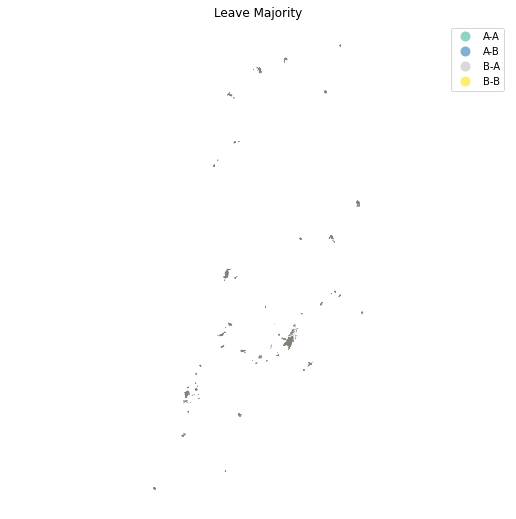

In [130]:
# ejercio  https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html
#  talvez toca convertir cl_Flag_AvgNal_CHURN en variable numerica pero mientras como ejemplo con flgAvgNalChurn_2021_12 
f, ax = plt.subplots(1, figsize=(9, 9))
df_fijaG3.plot(ax=ax, column='cl_Flag_AvgNal_CHURN', categorical=True, legend=True, 
        edgecolor='0.5', linewidth=0.25, cmap='Set3', 
        figsize=(9, 9));
ax.set_axis_off()
ax.set_title('Leave Majority')
plt.axis('equal')
plt.show()

In [ ]:
df_fijaG3['Flag_AvgNal_Tasa_2021'].describe()

count    13344.000000
mean         0.289256
std          0.192329
min          0.000000
25%          0.166667
50%          0.250000
75%          0.416667
max          1.000000
Name: Flag_AvgNal_Tasa_2021, dtype: float64

In [ ]:
df_fijaG3['w_Flag_AvgNal_CHURN'].describe()

count    13344.000000
mean         0.290248
std          0.103613
min          0.000000
25%          0.214148
50%          0.295815
75%          0.360855
max          0.788876
Name: w_Flag_AvgNal_CHURN, dtype: float64

In [ ]:
df_fijaG3.to_csv(os.path.join(result_dir, 'Fija\\Resultados\\df_fijaG3_pv_geo.csv'), sep = ';')
# C:\Users\WilsonAdolfoEstacioR\Documents\Proyect_churn\Fija\Resultados

In [ ]:
df_fijaG3.shape

(13344, 34)

In [ ]:
print(df_fijaG3.groupby('cl_Flag_AvgNal_CHURN').size())

cl_Flag_AvgNal_CHURN
A-A    6624
A-B     314
B-A     384
B-B    6022
dtype: int64


In [ ]:
# df_fijaG3[df_fijaG3['NODO'].isin(["SLX","IU6",'42C2D','SLJ',"SLW","49J"])].sort_values(by="cl_Flag_AvgNal_CHURN",ascending=True)

In [ ]:
Churn_alto=df_fijaG3[df_fijaG3['cl_Flag_AvgNal_CHURN']=='A-A']
Churn_alto.shape

(6624, 34)

In [ ]:
fija_mes10=df_fija1[df_fija1['FECHA'].dt.month == 10]
fija_mes10=fija_mes10.loc[:,['NODO','ESTRATO','ALFA','BETA','MEGA','TasaChurn']]

In [ ]:
df_fijaN10=pd.merge(Churn_alto, fija_mes10,on = ('NODO'), how='left')

In [ ]:
df_fijaN10.shape

(11636, 39)

In [ ]:
df_fijaN10.head(3)

,NODO,TIPO,geometry,Churn_2021_01,Churn_2021_02,Churn_2021_03,Churn_2021_04,Churn_2021_05,Churn_2021_06,Churn_2021_07,Churn_2021_08,Churn_2021_09,Churn_2021_10,Churn_2021_11,Churn_2021_12,flgAvgNalChurn_2021_01,flgAvgNalChurn_2021_02,flgAvgNalChurn_2021_03,flgAvgNalChurn_2021_04,flgAvgNalChurn_2021_05,flgAvgNalChurn_2021_06,flgAvgNalChurn_2021_07,flgAvgNalChurn_2021_08,flgAvgNalChurn_2021_09,flgAvgNalChurn_2021_10,flgAvgNalChurn_2021_11,flgAvgNalChurn_2021_12,Flag_AvgNal_2021,Flag_AvgNal_Tasa_2021,selecion,w_Flag_AvgNal_CHURN,Flag_AvgNal_Tasa_2021_std,w_Flag_AvgNal_CHURN_std,cl_Flag_AvgNal_CHURN,ESTRATO,ALFA,BETA,MEGA,TasaChurn
0,AMI,HFC,"POLYGON Z ((-8212900.894 444361.840 0.000, -82...",0.000000,0.02139,0.011080,0.007833,0.026961,0.007557,0.012285,0.007282,0.007126,0.011820,0.007194,0.013857,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.166667,1.0,0.300976,-0.637396,0.060935,A-A,2,NaN,0.622348,NaN,0.011820
1,AMI,HFC,"POLYGON Z ((-8212900.894 444361.840 0.000, -82...",0.000000,0.02139,0.011080,0.007833,0.026961,0.007557,0.012285,0.007282,0.007126,0.011820,0.007194,0.013857,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.166667,1.0,0.300976,-0.637396,0.060935,A-A,2,NaN,0.850858,NaN,0.011820
2,OMJ,HFC,"POLYGON Z ((-8213197.449 444885.309 0.000, -82...",0.004032,0.01581,0.016064,0.014706,0.017544,0.017182,0.010309,0.019608,0.013115,0.006803,0.023333,0.015528,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,0.333333,1.0,0.328534,0.229177,0.204221,A-A,1,NaN,0.758621,NaN,0.006803


In [ ]:
# print(df_fijaN10.groupby('Flag_AvgNal_Tasa_2021').size())

In [ ]:
# Nodos mas criticos mirandolos desde Flag_AvgNal_Tasa_2021
# df_fijaN10[df_fijaN10['Flag_AvgNal_Tasa_2021']>=1.0]

In [ ]:
df_fijaN10.isnull().sum().sort_values(ascending=False,)[:21]

ALFA                         2847
BETA                         2518
MEGA                         2445
TasaChurn                    1548
ESTRATO                      1548
Flag_AvgNal_2021                0
flgAvgNalChurn_2021_08          0
flgAvgNalChurn_2021_09          0
flgAvgNalChurn_2021_10          0
flgAvgNalChurn_2021_11          0
flgAvgNalChurn_2021_12          0
w_Flag_AvgNal_CHURN             0
Flag_AvgNal_Tasa_2021           0
selecion                        0
flgAvgNalChurn_2021_06          0
Flag_AvgNal_Tasa_2021_std       0
w_Flag_AvgNal_CHURN_std         0
cl_Flag_AvgNal_CHURN            0
flgAvgNalChurn_2021_07          0
NODO                            0
TIPO                            0
dtype: int64

## Alfa

In [ ]:
ALFA_mean=df_fijaN10["ALFA"].mean()
print(ALFA_mean)

ALFA_std=df_fijaN10["ALFA"].std()
print(ALFA_std)

primera_std_alfa=ALFA_mean+ALFA_std
print(primera_std_alfa)

1.880050449014808
3.529028626550251
5.409079075565059


In [ ]:
def semaforoVal_Exp(val):
    #df = df.copy()
    respuesta=0
    if (val<2):
        respuesta=0 
    elif val>=2:
        respuesta=1
    return(respuesta)

In [ ]:
df_fijaN10['ALFA_Exp']=df_fijaN10['ALFA'].apply(semaforoVal_Exp)   
print(df_fijaN10.groupby('ALFA_Exp').size())

ALFA_Exp
0    9002
1    2634
dtype: int64


In [ ]:
ALFA_criticos=df_fijaN10[df_fijaN10["ALFA_Exp"]==1]
ALFA_criticos.shape

(2634, 40)

In [ ]:
Mega_mean_nw=ALFA_criticos["MEGA"].mean()
print(Mega_mean_nw)

Mega_std_nw=ALFA_criticos["MEGA"].std()
print(Mega_std_nw)

primera_std_Mega=Mega_mean_nw+Mega_std_nw
print(primera_std_Mega)

1.7754653579377582
0.7440684415539802
2.5195337994917386


In [ ]:
ALFA_criticos['MEGA_Exp']=ALFA_criticos['MEGA'].apply(semaforoVal_Exp)   
print(ALFA_criticos.groupby('MEGA_Exp').size())

MEGA_Exp
0    1859
1     775
dtype: int64


C:\ProgramData\Anaconda3\envs\sqdm\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [ ]:
mega_crit=ALFA_criticos[ALFA_criticos["MEGA_Exp"]==1]
mega_crit.shape

(775, 41)

In [ ]:
print(mega_crit['ESTRATO'].mode())

0    3
dtype: object


## Beta

In [ ]:
ALFA_nocriticos=df_fijaN10[df_fijaN10["ALFA_Exp"]==0]
ALFA_nocriticos.shape

(9002, 40)

In [ ]:
# BETA_mean_nw=ALFA_nocriticos["BETA"].mean()
# print(BETA_mean_nw)

# BETA_std_nw=ALFA_nocriticos["BETA"].std()
# print(BETA_std_nw)

# primera_std_beta_nw=BETA_mean_nw+BETA_std_nw
# print(primera_std_beta_nw)

In [ ]:
def semaforoValBeta(val):
    #df = df.copy()
    respuesta=0
    if (val<1.5):
        respuesta=0 
    elif val>=1.5:
        respuesta=1
    return(respuesta)

In [ ]:
ALFA_nocriticos['BETA_Exp']=ALFA_nocriticos['BETA'].apply(semaforoValBeta) 
print(ALFA_nocriticos.groupby('BETA_Exp').size())

BETA_Exp
0    7514
1    1488
dtype: int64


In [ ]:
BETA_crit=ALFA_nocriticos[ALFA_nocriticos["BETA_Exp"]==1]
BETA_crit.shape

(1488, 41)

## unificamos bases de datos

In [ ]:
df_fijaN10.shape

(11636, 40)

In [ ]:
BETA_crit=BETA_crit.loc[:,['NODO','BETA_Exp']]
mega_crit=mega_crit.loc[:,['NODO','MEGA_Exp']]

In [ ]:
# print(ALFA_nocriticos.groupby('BETA_Exp').size())

In [ ]:
fijaN11=pd.merge(df_fijaN10, mega_crit, on = ('NODO'), how='left')

In [ ]:
# print(fijaN11.groupby('MEGA_Exp').size())
# print(fijaN11.groupby('ALFA_Exp').size())

#### hasta qui bien

In [ ]:
fijaN12=pd.merge(fijaN11, BETA_crit, on = ('NODO'), how='left')

In [ ]:
fijaN12.shape

(12124, 42)

In [ ]:
fijaN12.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
fijaN12.head(2)

,NODO,TIPO,geometry,Churn_2021_01,Churn_2021_02,Churn_2021_03,Churn_2021_04,Churn_2021_05,Churn_2021_06,Churn_2021_07,Churn_2021_08,Churn_2021_09,Churn_2021_10,Churn_2021_11,Churn_2021_12,flgAvgNalChurn_2021_01,flgAvgNalChurn_2021_02,flgAvgNalChurn_2021_03,flgAvgNalChurn_2021_04,flgAvgNalChurn_2021_05,flgAvgNalChurn_2021_06,flgAvgNalChurn_2021_07,flgAvgNalChurn_2021_08,flgAvgNalChurn_2021_09,flgAvgNalChurn_2021_10,flgAvgNalChurn_2021_11,flgAvgNalChurn_2021_12,Flag_AvgNal_2021,Flag_AvgNal_Tasa_2021,selecion,w_Flag_AvgNal_CHURN,Flag_AvgNal_Tasa_2021_std,w_Flag_AvgNal_CHURN_std,cl_Flag_AvgNal_CHURN,ESTRATO,ALFA,BETA,MEGA,TasaChurn,ALFA_Exp,MEGA_Exp,BETA_Exp
0,AMI,HFC,"POLYGON Z ((-8212900.894 444361.840 0.000, -82...",0.0,0.02139,0.01108,0.007833,0.026961,0.007557,0.012285,0.007282,0.007126,0.01182,0.007194,0.013857,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.166667,1.0,0.300976,-0.637396,0.060935,A-A,2,NaN,0.622348,NaN,0.01182,0,NaN,NaN
1,AMI,HFC,"POLYGON Z ((-8212900.894 444361.840 0.000, -82...",0.0,0.02139,0.01108,0.007833,0.026961,0.007557,0.012285,0.007282,0.007126,0.01182,0.007194,0.013857,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.166667,1.0,0.300976,-0.637396,0.060935,A-A,2,NaN,0.850858,NaN,0.01182,0,NaN,NaN


In [ ]:
print(fijaN12.groupby('BETA_Exp').size())

BETA_Exp
1.0    2995
dtype: int64


## Analsis para alfa y mega

In [ ]:
df_fija1.head(2)

,NODO,FECHA,CANTIDAD_CHURN,ESTRATO,MOTIVO_DESCONEXION,EDAD,RENTA,RENTA_ACT,PROM_RENTA_ACT,CANTIDAD,MODA_ESTRATO,ALFA,BETA,MEGA,CANTIDAD_ACTIVOS,TasaChurn,FechaVal_AñoMes
0,01J,2021-05-01,1,3,TRASLADO,59.0,65318,2856137.0,109851.0,26.0,3,NaN,NaN,0.391503,27,0.037037,Churn_2021_05
1,01J,2021-05-01,1,3,TRASLADO,59.0,65318,2856137.0,109851.0,26.0,3,NaN,NaN,NaN,27,0.037037,Churn_2021_05


In [ ]:
df_fija1['FechaVal_ALFA'] = df_fija1['FECHA'].dt.strftime('ALFA_''%Y_%m')
df_fija1['FechaVal_BETA'] = df_fija1['FECHA'].dt.strftime('BETA_''%Y_%m')
df_fija1['FechaVal_MEGA'] = df_fija1['FECHA'].dt.strftime('MEGA_''%Y_%m')

C:\Users\WILSON~1\AppData\Local\Temp/ipykernel_20876/3190443494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fija1['FechaVal_ALFA'] = df_fija1['FECHA'].dt.strftime('ALFA_''%Y_%m')
C:\Users\WILSON~1\AppData\Local\Temp/ipykernel_20876/3190443494.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fija1['FechaVal_BETA'] = df_fija1['FECHA'].dt.strftime('BETA_''%Y_%m')
C:\Users\WILSON~1\AppData\Local\Temp/ipykernel_20876/3190443494.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [ ]:
Ul_months=df_fija1[df_fija1['FECHA'] > '2021-07-1']
Ul_months.head()

,NODO,FECHA,CANTIDAD_CHURN,ESTRATO,MOTIVO_DESCONEXION,EDAD,RENTA,RENTA_ACT,PROM_RENTA_ACT,CANTIDAD,MODA_ESTRATO,ALFA,BETA,MEGA,CANTIDAD_ACTIVOS,TasaChurn,FechaVal_AñoMes,FechaVal_ALFA,FechaVal_BETA,FechaVal_MEGA
4,01J,2021-08-01,1,3,FALLAS SERVICIO (CALIDAD),64.0,50301,2507252.0,109011.0,23.0,3,3.367969,2.600000,1.295373,24,0.041667,Churn_2021_08,ALFA_2021_08,BETA_2021_08,MEGA_2021_08
5,01J,2021-08-01,1,3,FALLAS SERVICIO (CALIDAD),64.0,50301,2507252.0,109011.0,23.0,3,NaN,1.942857,NaN,24,0.041667,Churn_2021_08,ALFA_2021_08,BETA_2021_08,MEGA_2021_08
6,01J,2021-09-01,1,3,PRECIO Y CAPACIDAD DE PAGO,64.0,163800,2702401.0,112600.0,24.0,3,0.320868,1.209302,0.265333,25,0.040000,Churn_2021_09,ALFA_2021_09,BETA_2021_09,MEGA_2021_09
7,01J,2021-09-01,1,3,PRECIO Y CAPACIDAD DE PAGO,64.0,163800,2702401.0,112600.0,24.0,3,0.277625,1.515152,0.183232,25,0.040000,Churn_2021_09,ALFA_2021_09,BETA_2021_09,MEGA_2021_09
8,01J,2021-12-01,1,3,PRECIO Y CAPACIDAD DE PAGO,69.0,81517,2627094.0,105084.0,25.0,3,NaN,NaN,NaN,26,0.038462,Churn_2021_12,ALFA_2021_12,BETA_2021_12,MEGA_2021_12


In [ ]:
Ul_months.mean()

C:\Users\WILSON~1\AppData\Local\Temp/ipykernel_20876/635210532.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  Ul_months.mean()
C:\Users\WILSON~1\AppData\Local\Temp/ipykernel_20876/635210532.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Ul_months.mean()


CANTIDAD_CHURN      3.742601e+00
EDAD                4.257020e+01
RENTA               3.659952e+05
RENTA_ACT           2.441112e+07
PROM_RENTA_ACT      1.049403e+05
CANTIDAD            2.431104e+02
ALFA                1.501901e+00
BETA                1.517812e+00
MEGA                1.003683e+00
CANTIDAD_ACTIVOS    2.468530e+02
TasaChurn           1.768403e-02
dtype: float64

In [ ]:
Ul_months.shape

(105082, 20)

In [ ]:
Ul_months_pvaLFA = pd.pivot_table(Ul_months, index = "NODO", columns=['FechaVal_ALFA'], values='ALFA')
Ul_months_pvaLFA.fillna(0,inplace=True)
Ul_months_pvaLFA = Ul_months_pvaLFA.reset_index()
Ul_months_pvaLFA.head()

FechaVal_ALFA,NODO,ALFA_2021_08,ALFA_2021_09,ALFA_2021_10,ALFA_2021_11,ALFA_2021_12
0,01J,3.367969,0.299246,0.000000,0.000000,0.000000
1,01S,0.800865,0.000000,0.875057,0.670245,1.040150
2,02S,1.096901,0.601890,1.123184,3.256095,1.570392
3,04J,0.000000,0.967865,0.000000,0.000000,0.000000
4,05J,3.938181,2.497465,0.000000,20.952055,0.000000


In [ ]:
Ul_months_pvaLFA.shape

(12037, 6)

In [ ]:
Ul_months_pvBETA = pd.pivot_table(Ul_months, index = "NODO", columns=['FechaVal_BETA'], values='BETA')
Ul_months_pvBETA.fillna(0,inplace=True)
Ul_months_pvBETA = Ul_months_pvBETA.reset_index()
Ul_months_pvBETA.head()

FechaVal_BETA,NODO,BETA_2021_08,BETA_2021_09,BETA_2021_10,BETA_2021_11,BETA_2021_12
0,01J,2.271429,1.362227,0.000000,0.000000,0.000000
1,01S,0.902511,0.000000,1.277691,0.942026,1.303360
2,02J,0.670250,0.000000,0.000000,0.000000,0.000000
3,02S,1.060743,1.099935,1.366990,3.601254,1.808118
4,03J,0.000000,0.838336,1.428571,0.000000,0.000000


In [ ]:
Ul_months_pvBETA.shape

(12356, 6)

In [ ]:
Ul_months_pvMEGA = pd.pivot_table(Ul_months, index = "NODO", columns=['FechaVal_MEGA'], values='MEGA')
Ul_months_pvMEGA.fillna(0,inplace=True)
Ul_months_pvMEGA = Ul_months_pvMEGA.reset_index()
Ul_months_pvMEGA.head()

FechaVal_MEGA,NODO,MEGA_2021_08,MEGA_2021_09,MEGA_2021_10,MEGA_2021_11,MEGA_2021_12
0,01J,1.295373,0.224283,0.000000,0.000000,1.859166
1,01S,0.827054,0.000000,0.648060,0.707915,0.775207
2,02S,1.001564,0.607911,0.819028,0.932159,0.953979
3,04J,0.000000,0.755993,0.051785,0.000000,0.000000
4,05J,1.820208,1.778992,4.052769,2.316571,0.000000


In [ ]:
Ul_months_pvMEGA.shape

(12180, 6)

In [ ]:
Ul_W1=pd.merge(Ul_months,Ul_months_pvaLFA , on = ('NODO'), how='left')

In [ ]:
Ul_W2=pd.merge(Ul_W1,Ul_months_pvBETA , on = ('NODO'), how='left')

In [ ]:
Ul_W3=pd.merge(Ul_W2,Ul_months_pvMEGA , on = ('NODO'), how='left')
Ul_W3=Ul_W3.drop(['FECHA','CANTIDAD_CHURN','ESTRATO','MOTIVO_DESCONEXION','EDAD','CANTIDAD','ALFA','BETA','MEGA','CANTIDAD_ACTIVOS','TasaChurn','FechaVal_AñoMes','FechaVal_ALFA','FechaVal_BETA','FechaVal_MEGA'], axis=1)

In [ ]:
Ul_W3.shape

(105082, 20)

In [ ]:
Ul_W3.describe()

,RENTA,RENTA_ACT,PROM_RENTA_ACT,ALFA_2021_08,ALFA_2021_09,ALFA_2021_10,ALFA_2021_11,ALFA_2021_12,BETA_2021_08,BETA_2021_09,BETA_2021_10,BETA_2021_11,BETA_2021_12,MEGA_2021_08,MEGA_2021_09,MEGA_2021_10,MEGA_2021_11,MEGA_2021_12
count,1.050820e+05,1.050820e+05,105082.000000,98825.000000,98825.000000,98825.000000,98825.000000,98825.000000,100734.000000,100734.000000,100734.000000,100734.000000,100734.000000,99386.000000,99386.000000,99386.000000,99386.000000,99386.000000
mean,3.659952e+05,2.441112e+07,104940.314650,1.165894,1.212977,1.240299,1.300869,1.316990,1.286825,1.360907,1.371223,1.300284,1.311124,0.829963,0.812281,0.835493,0.871832,0.896751
std,3.283689e+05,1.441641e+07,18685.971729,2.062511,2.233932,2.145773,2.313055,2.086119,1.427333,1.726587,2.108555,1.564572,1.578704,0.642150,0.679239,0.634748,0.690236,0.697377
min,0.000000e+00,5.000000e+04,12306.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.501010e+05,1.314553e+07,92316.000000,0.333424,0.376434,0.354855,0.292346,0.304821,0.908537,0.966170,0.944452,0.899936,0.888829,0.321064,0.331884,0.328146,0.282251,0.292945
50%,2.848810e+05,2.258926e+07,105117.000000,0.895816,0.937460,0.944443,0.944745,0.987066,1.176994,1.239040,1.220699,1.186813,1.166451,0.767859,0.760440,0.778424,0.797426,0.832342
75%,4.805882e+05,3.317892e+07,114811.000000,1.587431,1.626035,1.670830,1.776398,1.790163,1.500455,1.542031,1.546391,1.508228,1.502722,1.213976,1.201116,1.241533,1.329966,1.365112
max,8.991263e+06,1.213819e+08,226532.000000,162.008866,97.639648,90.835938,107.352539,141.686617,65.558824,73.000000,107.000000,64.000000,65.102740,8.260896,34.352322,6.036372,8.893164,6.226692


In [ ]:
# para alfa
PromedioTrimALFA = 1.5 # 0.018

Ul_W3.loc[(Ul_W3['ALFA_2021_08']>PromedioTrimALFA),'flgAvgTrimALFA_2021_08'] = 1
Ul_W3.loc[(Ul_W3['ALFA_2021_09']>PromedioTrimALFA),'flgAvgTrimALFA_2021_09'] = 1
Ul_W3.loc[(Ul_W3['ALFA_2021_10']>PromedioTrimALFA),'flgAvgTrimALFA_2021_10'] = 1
Ul_W3.fillna(0,inplace=True)
# para beta
PromedioTrimBETA = 1.7 # 0.018
Ul_W3.loc[(Ul_W3['BETA_2021_08']>PromedioTrimBETA),'flgAvgTrimBETA_2021_08'] = 1
Ul_W3.loc[(Ul_W3['BETA_2021_09']>PromedioTrimBETA),'flgAvgTrimBETA_2021_09'] = 1
Ul_W3.loc[(Ul_W3['BETA_2021_10']>PromedioTrimBETA),'flgAvgTrimBETA_2021_10'] = 1
Ul_W3.fillna(0,inplace=True)
# para mega
PromedioTrimMEGA = 0.9 # 0.018
Ul_W3.loc[(Ul_W3['MEGA_2021_08']>PromedioTrimMEGA),'flgAvgTrimMEGA_2021_08'] = 1
Ul_W3.loc[(Ul_W3['MEGA_2021_09']>PromedioTrimMEGA),'flgAvgTrimMEGA_2021_09'] = 1
Ul_W3.loc[(Ul_W3['MEGA_2021_10']>PromedioTrimMEGA),'flgAvgTrimMEGA_2021_10'] = 1
Ul_W3.fillna(0,inplace=True)

In [ ]:
Ul_W3

,NODO,RENTA,RENTA_ACT,PROM_RENTA_ACT,MODA_ESTRATO,ALFA_2021_08,ALFA_2021_09,ALFA_2021_10,ALFA_2021_11,ALFA_2021_12,BETA_2021_08,BETA_2021_09,BETA_2021_10,BETA_2021_11,BETA_2021_12,MEGA_2021_08,MEGA_2021_09,MEGA_2021_10,MEGA_2021_11,MEGA_2021_12,flgAvgTrimALFA_2021_08,flgAvgTrimALFA_2021_09,flgAvgTrimALFA_2021_10,flgAvgTrimBETA_2021_08,flgAvgTrimBETA_2021_09,flgAvgTrimBETA_2021_10,flgAvgTrimMEGA_2021_08,flgAvgTrimMEGA_2021_09,flgAvgTrimMEGA_2021_10
0,01J,50301,2507252.0,109011.0,3,3.367969,0.299246,0.00000,0.000000,0.000000,2.271429,1.362227,0.000000,0.000000,0.000000,1.295373,0.224283,0.000000,0.00000,1.859166,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,01J,50301,2507252.0,109011.0,3,3.367969,0.299246,0.00000,0.000000,0.000000,2.271429,1.362227,0.000000,0.000000,0.000000,1.295373,0.224283,0.000000,0.00000,1.859166,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,01J,163800,2702401.0,112600.0,3,3.367969,0.299246,0.00000,0.000000,0.000000,2.271429,1.362227,0.000000,0.000000,0.000000,1.295373,0.224283,0.000000,0.00000,1.859166,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,01J,163800,2702401.0,112600.0,3,3.367969,0.299246,0.00000,0.000000,0.000000,2.271429,1.362227,0.000000,0.000000,0.000000,1.295373,0.224283,0.000000,0.00000,1.859166,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,01J,81517,2627094.0,105084.0,3,3.367969,0.299246,0.00000,0.000000,0.000000,2.271429,1.362227,0.000000,0.000000,0.000000,1.295373,0.224283,0.000000,0.00000,1.859166,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105077,ZVZ,571547,49136627.0,110419.0,3,1.713209,1.837979,0.85407,1.586839,1.226907,1.224710,1.445795,0.951412,1.244056,0.993745,1.502485,1.316430,0.969955,1.38083,1.312804,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
105078,ZVZ,455530,48974972.0,109564.0,3,1.713209,1.837979,0.85407,1.586839,1.226907,1.224710,1.445795,0.951412,1.244056,0.993745,1.502485,1.316430,0.969955,1.38083,1.312804,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
105079,ZVZ,455530,48974972.0,109564.0,3,1.713209,1.837979,0.85407,1.586839,1.226907,1.224710,1.445795,0.951412,1.244056,0.993745,1.502485,1.316430,0.969955,1.38083,1.312804,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
105080,ZVZ,933242,49500451.0,109273.0,3,1.713209,1.837979,0.85407,1.586839,1.226907,1.224710,1.445795,0.951412,1.244056,0.993745,1.502485,1.316430,0.969955,1.38083,1.312804,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [ ]:
# para alfa
Ul_W3["Flag_AvgTrimALFA_2021"] = Ul_W3.filter(like='flgAvgTrimALFA_2021').sum(axis=1)
Ul_W3["Flag_AvgTrimALFA_total"] = Ul_W3.filter(like='flgAvgTrimALFA_2021').sum(axis=1)/Ul_W3.filter(like='flgAvgTrimALFA_2021').count(axis=1)
# para beta
Ul_W3["Flag_AvgTrimBETA_2021"] = Ul_W3.filter(like='flgAvgTrimBETA_2021').sum(axis=1)
Ul_W3["Flag_AvgTrimBETA_total"] = Ul_W3.filter(like='flgAvgTrimBETA_2021').sum(axis=1)/Ul_W3.filter(like='flgAvgTrimBETA_2021').count(axis=1)
# para mega
Ul_W3["Flag_AvgTrimMEGA_2021"] = Ul_W3.filter(like='flgAvgTrimMEGA_2021').sum(axis=1)
Ul_W3["Flag_AvgTrimMEGA_total"] = Ul_W3.filter(like='flgAvgTrimMEGA_2021').sum(axis=1)/Ul_W3.filter(like='flgAvgTrimMEGA_2021').count(axis=1)

# df_fija_pv["Flag_AvgNal_2021"] = df_fija_pv.filter(like='flgAvgNalChurn_2021').sum(axis=1)
# df_fija_pv["Flag_AvgNal_Tasa_2021"] = df_fija_pv.filter(like='flgAvgNalChurn_2021').sum(axis=1)/df_fija_pv.filter(like='flgAvgNalChurn_2021').count(axis=1)

In [ ]:
Ul_W3['Seccion']=1

In [ ]:
Ul_W3.shape

(105082, 36)

In [ ]:
# print(Ul_W3.groupby('Flag_AvgTrimALFA_2021_total').size())

In [ ]:
MSH.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
df_fijaABM = pd.merge(left = MSH, right = Ul_W3, how = 'left', left_on = 'NODO', right_on = 'NODO')

In [ ]:
df_fijaABM=df_fijaABM[df_fijaABM['Seccion']==1]

In [ ]:
df_fijaABM.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
#NodosChurnActivosFija_pv_geo.reset_index(inplace=True)
# threshold= 28522 es el de por defecto segun argis
coords = points_to_coords(df_fijaABM.geometry.centroid)
q_d=weights.DistanceBand(coords, threshold=6441, binary=False)##Límite en grados 1/200 ~ 555 mt.
q_d.transform='R'
TasaCompare_ALFA = df_fijaABM['Flag_AvgTrimALFA_total']
df_fijaABM['w_Flag_AvgTri_ALFA']=weights.spatial_lag.lag_spatial(q_d, TasaCompare_ALFA)

TasaCompare_BETA = df_fijaABM['Flag_AvgTrimBETA_total']
df_fijaABM['w_Flag_AvgTri_BETA']=weights.spatial_lag.lag_spatial(q_d, TasaCompare_BETA)

TasaCompare_MEGA = df_fijaABM['Flag_AvgTrimMEGA_total']
df_fijaABM['w_Flag_AvgTri_MEGA']=weights.spatial_lag.lag_spatial(q_d, TasaCompare_MEGA)

MemoryError: Unable to allocate 4.15 GiB for an array with shape (556762812,) and data type float64

In [ ]:
df_fijaABM['Flag_AvgTrimALFA_total_std'] = ( TasaCompare_ALFA - TasaCompare_ALFA.mean() )/ TasaCompare_ALFA.std()
df_fijaABM['w_Flag_AvgTri_ALFA_std'] = ( df_fijaABM['w_Flag_AvgTri_ALFA'] - TasaCompare_ALFA.mean() )/ TasaCompare_ALFA.std()

df_fijaABM['Flag_AvgTrimBETA_total_std'] = ( TasaCompare_BETA - TasaCompare_BETA.mean() )/ TasaCompare_BETA.std()
df_fijaABM['w_Flag_AvgTri_BETA_std'] = ( df_fijaABM['w_Flag_AvgTri_BETA'] - TasaCompare_BETA.mean() )/ TasaCompare_BETA.std()

df_fijaABM['Flag_AvgTrimMEGA_total_std'] = ( TasaCompare_MEGA - TasaCompare_MEGA.mean() )/ TasaCompare_MEGA.std()
df_fijaABM['w_Flag_AvgTri_MEGA_std'] = ( df_fijaABM['w_Flag_AvgTri_MEGA'] - TasaCompare_MEGA.mean() )/ TasaCompare_MEGA.std()

In [ ]:
# fig, (ax, ax1) = plt.subplots(1,figsize=(6,7))
f, ax = plt.subplots(1, figsize=(6, 6))

sns.regplot(x='Flag_AvgTrimALFA_total_std', y='w_Flag_AvgTri_ALFA_std', 
                ci=None, data=df_fijaABM, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot -ALFA - % Leave')
plt.show()

f, ax1 = plt.subplots(1, figsize=(6, 6))

sns.regplot(x='Flag_AvgTrimBETA_total_std', y='w_Flag_AvgTri_BETA_std', 
                ci=None, data=df_fijaABM, line_kws={'color':'r'})
ax1.axvline(0, c='k', alpha=0.5)
ax1.axhline(0, c='k', alpha=0.5)
ax1.set_title('Moran Plot- BETA - % Leave')
plt.show()

f, ax1 = plt.subplots(1, figsize=(6, 6))

sns.regplot(x='Flag_AvgTrimMEGA_total_std', y='w_Flag_AvgTri_MEGA_std', 
                ci=None, data=df_fijaABM, line_kws={'color':'r'})
ax1.axvline(0, c='k', alpha=0.5)
ax1.axhline(0, c='k', alpha=0.5)
ax1.set_title('Moran Plot-MEGA - % Leave')
plt.show()

In [ ]:
lisa_cuenta = esda.moran.Moran_Local(df_fijaABM['w_Flag_AvgTri_BETA'], q_d)
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]

df_fijaABM['cl_Flag_AvgTrimBETA']=labels_cuenta
df_fijaABM['cl_Flag_AvgTrimBETA']=df_fijaABM['cl_Flag_AvgTrimBETA'].apply(lambda x: 'A-A' if x=='Q1' else ('B-A' if x=='Q2' else ('B-B' if x=='Q3' else 'A-B')) )


In [ ]:
lisa_cuenta = esda.moran.Moran_Local(df_fijaABM['w_Flag_AvgTri_ALFA'], q_d)
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]

df_fijaABM['cl_Flag_AvgTrimALFA']=labels_cuenta
df_fijaABM['cl_Flag_AvgTrimALFA']=df_fijaABM['cl_Flag_AvgTrimALFA'].apply(lambda x: 'A-A' if x=='Q1' else ('B-A' if x=='Q2' else ('B-B' if x=='Q3' else 'A-B')) )

In [ ]:
lisa_cuenta = esda.moran.Moran_Local(df_fijaABM['w_Flag_AvgTri_MEGA'], q_d)
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]

df_fijaABM['cl_Flag_AvgTrimMEGA']=labels_cuenta
df_fijaABM['cl_Flag_AvgTrimMEGA']=df_fijaABM['cl_Flag_AvgTrimMEGA'].apply(lambda x: 'A-A' if x=='Q1' else ('B-A' if x=='Q2' else ('B-B' if x=='Q3' else 'A-B')) )

In [ ]:
df_fijaABM.head(5)

In [ ]:
df_fijaABM.shape

In [ ]:
print(df_fijaABM.groupby('cl_Flag_AvgTrimALFA').size())
print('='*64)
print(df_fijaABM.groupby('cl_Flag_AvgTrimBETA').size())
print('='*64)
print(df_fijaABM.groupby('cl_Flag_AvgTrimMEGA').size())

In [ ]:
df_fijaABM.to_file(os.path.join(result_dir, 'Fija\\Resultados\\df_fijaABM.geojson'), driver = 'GeoJSON')

In [ ]:
# MGN_DANE_SECT_CobFTTH.to_file('MGN_DANE/MGN_DANE_SECT_CobFTTH.shp')
df_fijaABM.to_file(os.path.join(result_dir, 'Fija\\Resultados\\df_fijaABM.shp'), driver = 'GeoJSON')

# Analisis de Rentas. CR

In [ ]:
## se desea analizar que nodos tienen mas perdida de dinero y cuanto dinero estamos perdiendo y que nodos  son los que mas nos generan rentavilidad para estar protegiendolos. y que nodos tienen mayor cantidad de usuarios.

In [ ]:
df_fija_CM.shape

In [ ]:
# df_fija_CM=df_fija1.copy()
df_fija_CM1=df_fija_CM.drop(['FechaVal_AñoMes','ESTRATO'], axis=1)
df_fija_CM1['Porcentaje_Perdida']=(df_fija_CM['RENTA']/((df_fija_CM['RENTA']+df_fija_CM['RENTA_ACT']))*100)

In [ ]:
# TasaChurn*RENTA_ACT=si
df_fija_CM1['CR']=df_fija_CM1['TasaChurn']*df_fija_CM1['RENTA_ACT']

In [ ]:
df_fija_CM1.shape

In [ ]:
df_fija_CM1.describe([.01,.1,.2,.25,.3,.4,.5,.6,.7,.75,.8,.9,.99])

In [ ]:
df_fija_CM1[df_fija_CM1['CR']>3.577947e+05]

In [ ]:
by_renta = df_fija_CM1.sort_values('CR',ascending=False)
by_renta.head(2)

In [ ]:
# M_inueble=df_fija_CM1["MOTIVO_DESCONEXION"].value_counts()[:30]
# print(M_inueble)
# M_inueble_IMPORTANTES=M_inueble[:20]
# plt.figure(figsize=(5,9))
# plt.title('Indicador estrato social')
# plt.xlabel('Numero de inmuebles')
# plt.ylabel('Estrato social')
# M_inueble_IMPORTANTES.plot.barh()

In [ ]:
df_fija_CM1['FechaVal_CR'] = df_fija_CM1['FECHA'].dt.strftime('CR_''%Y_%m')

In [ ]:
df_fija_CM1_pv = pd.pivot_table(df_fija_CM1, index = "NODO", columns=['FechaVal_CR'], values='CR')
df_fija_CM1_pv.fillna(0,inplace=True)
df_fija_CM1_pv = df_fija_CM1_pv.reset_index()
# df_fija_pv.to_csv(os.path.join(result_dir,'Fija\\Resultados\\ChurnActivosFijaPivot.csv'), sep = ';')

In [ ]:
df_fija_CM1_pv

In [ ]:
#Banderas CR superior a promedio NAL
PromedioNal = 3.577947e+05 # 0.018

df_fija_CM1_pv.loc[(df_fija_CM1_pv['CR_2021_01']>PromedioNal),'flgAvgNalCR_2021_01'] = 1
df_fija_CM1_pv.loc[(df_fija_CM1_pv['CR_2021_02']>PromedioNal),'flgAvgNalCR_2021_02'] = 1
df_fija_CM1_pv.loc[(df_fija_CM1_pv['CR_2021_03']>PromedioNal),'flgAvgNalCR_2021_03'] = 1
df_fija_CM1_pv.loc[(df_fija_CM1_pv['CR_2021_04']>PromedioNal),'flgAvgNalCR_2021_04'] = 1
df_fija_CM1_pv.loc[(df_fija_CM1_pv['CR_2021_05']>PromedioNal),'flgAvgNalCR_2021_05'] = 1
df_fija_CM1_pv.loc[(df_fija_CM1_pv['CR_2021_06']>PromedioNal),'flgAvgNalCR_2021_06'] = 1
df_fija_CM1_pv.loc[(df_fija_CM1_pv['CR_2021_07']>PromedioNal),'flgAvgNalCR_2021_07'] = 1
df_fija_CM1_pv.loc[(df_fija_CM1_pv['CR_2021_08']>PromedioNal),'flgAvgNalCR_2021_08'] = 1
df_fija_CM1_pv.loc[(df_fija_CM1_pv['CR_2021_09']>PromedioNal),'flgAvgNalCR_2021_09'] = 1
df_fija_CM1_pv.loc[(df_fija_CM1_pv['CR_2021_10']>PromedioNal),'flgAvgNalCR_2021_10'] = 1

df_fija_CM1_pv.fillna(0,inplace=True)

In [ ]:
df_fija_CM1_pv

In [ ]:
#Calculo promedio por nodo superior a CR 
df_fija_CM1_pv["Flag_AvgCR_2021"] = df_fija_CM1_pv.filter(like='flgAvgNalCR_2021').sum(axis=1)
df_fija_CM1_pv["Flag_AvgNal_CR_2021"] = df_fija_CM1_pv.filter(like='flgAvgNalCR_2021').sum(axis=1)/df_fija_CM1_pv.filter(like='flgAvgNalCR_2021').count(axis=1)

In [ ]:
df_fija_CM1_pv.sample(4)

In [ ]:
df_fija_CM1_pv['Selecion_CR']=1

In [ ]:
df_fija_CM1_pv["Selecion_CR"].value_counts()[:30]

In [ ]:
df_fija_CM1_pv.sample(5)

### Lisa

In [ ]:
# MSH
fija_CM2_pv = pd.merge(left = MSH, right = df_fija_CM1_pv, how = 'left', left_on = 'NODO', right_on = 'NODO')

In [ ]:
fija_CM2_pv.crs

In [ ]:
fija_CM3_pv=fija_CM2_pv[fija_CM2_pv['Selecion_CR']==1]

In [ ]:
fija_CM3_pv.shape

In [ ]:
#NodosChurnActivosFija_pv_geo.reset_index(inplace=True)
coords1 = points_to_coords(fija_CM3_pv.geometry.centroid)
q_d=weights.DistanceBand(coords1, threshold=955, binary=False)##Límite en grados 1/200 ~ 555 mt.
q_d.transform='R'
TasaCompare1 = fija_CM3_pv['Flag_AvgNal_CR_2021']
fija_CM3_pv['w_Flag_AvgNal_CR']=weights.spatial_lag.lag_spatial(q_d, TasaCompare1)

In [ ]:
moran = esda.moran.Moran(fija_CM3_pv['Flag_AvgNal_CR_2021'], q_d)

In [ ]:
moran.I # el valor de la I de Moran se corresponde con la pendiente del ajuste lineal sobrepuesto en la parte superior de la trama de Moran.

In [ ]:
moran.p_sim  # medida de certeza sobre la probabilidad de obtener un patrón

In [ ]:
fija_CM3_pv['Flag_AvgNal_CR_2021_std'] = ( TasaCompare1 - TasaCompare1.mean() )/ TasaCompare1.std()
fija_CM3_pv['w_Flag_AvgNal_CR_2021_std'] = ( fija_CM3_pv['w_Flag_AvgNal_CR'] - TasaCompare1.mean() )/ TasaCompare1.std()

In [ ]:
fija_CM3_pv.head()

In [ ]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x='Flag_AvgNal_CR_2021_std', y='w_Flag_AvgNal_CR_2021_std', 
                ci=None, data=fija_CM3_pv, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - % Leave')
plt.show()

In [ ]:
lisa_cuenta = esda.moran.Moran_Local(fija_CM3_pv['w_Flag_AvgNal_CR'], q_d)
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels_cuenta = [q_labels[i-1] for i in lisa_cuenta.q]

fija_CM3_pv['cl_Flag_AvgNal_CR']=labels_cuenta
fija_CM3_pv['cl_Flag_AvgNal_CR']=fija_CM3_pv['cl_Flag_AvgNal_CR'].apply(lambda x: 'A-A' if x=='Q1' else ('B-A' if x=='Q2' else ('B-B' if x=='Q3' else 'A-B')) )

In [ ]:
fija_CM3_pv[fija_CM3_pv['NODO'].isin(["G1Y","C47",'ALX',"PIH"])] # es para ejemplo donde sabemos que los dos primeros tienen que ser altos y los dos ultimos tienen que dar bajo bajo

In [ ]:
print(fija_CM3_pv.groupby('cl_Flag_AvgNal_CR').size())

In [ ]:
fija_CM3_pv.to_file(os.path.join(result_dir, 'Fija\\Resultados\\fija_CM3_pv.shp'), driver = 'GeoJSON')

In [ ]:
# # creamos nivel indicador
# df_fija_CM1['INDICADOR_CR'] = 'Desconocido'
# df_fija_CM1.loc[df_fija_CM1['CR'].between(0.00 , 1.235211e+05, inclusive=True),   'INDICADOR_CR'] = 'Bajo'
# df_fija_CM1.loc[df_fija_CM1['CR'].between(1.049458e+05, 2.251763e+05, inclusive=True),   'INDICADOR_CR'] = 'Regular'
# df_fija_CM1.loc[df_fija_CM1['CR'].between(2.251763e+05, 4.257996e+05, inclusive=True), 'INDICADOR_CR'] = 'Alto'
# df_fija_CM1.loc[df_fija_CM1['CR'].between(4.257996e+05, 6.622371e+06, inclusive=True), 'INDICADOR_CR'] = 'Critico'

In [ ]:
# df_fija_CM12=df_fija_CM.groupby(['NODO','FECHA']).agg({'NODO':'count','ESTRATO':pd.Series.mode,'MOTIVO_DESCONEXION':pd.Series.mode,'EDAD':np.mean,'RENTA':'sum','RENTA_ACT':'sum','PROM_RENTA_ACT':'sum',
#                                                       'ALFA':np.mean,'BETA':np.mean,'MEGA':np.mean,'CANTIDAD_ACTIVOS':'sum',})

In [ ]:
# end = datetime.now()
# print(f'Tiempo: {end - start} segundos')